<a href="https://colab.research.google.com/github/rayoo22/MNIST-ImageClassifier/blob/main/multiclassifier_and_binary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, trim, rand
from google.colab import drive
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

In [10]:
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
spark = SparkSession.builder.appName("UNSW-NB15 Binary Classifier").getOrCreate()

In [18]:
df = spark.read.csv('/content/drive/MyDrive/UNSW-NB15.csv', header=False, inferSchema=True)
feature_df = spark.read.csv('/content/drive/MyDrive/UNSW-NB15_features.csv', header=True)

In [19]:
feature_names = [row['Name'] for row in feature_df.collect()]

In [20]:
df = df.toDF(*feature_names)

In [21]:
df.show(5)

+----------+-----+-------------+------+-----+-----+-----------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+----------+------------+------------+------------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|        dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt|   Dintpkt|      tcprtt|      synack|      ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+---------

In [ ]:
# DATA EXPLORATION AND PREPROCESSING

In [22]:
# Handle null
df = df.fillna({'attack_cat': 'Normal'})
df = df.withColumn("attack_cat", trim(col("attack_cat")))

In [23]:
df = df.withColumnRenamed("ct_src_ ltm", "ct_src_ltm")

In [24]:
df.show(5)

+----------+-----+-------------+------+-----+-----+-----------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+----------+------------+------------+------------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|        dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt|   Dintpkt|      tcprtt|      synack|      ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+----------+

In [25]:
df.groupBy("attack_cat").count().orderBy("count", ascending=False).show()

+--------------+-------+
|    attack_cat|  count|
+--------------+-------+
|        Normal|2218456|
|       Generic| 215481|
|      Exploits|  44525|
|       Fuzzers|  24246|
|           DoS|  16353|
|Reconnaissance|  13987|
|      Analysis|   2677|
|      Backdoor|   1795|
|     Shellcode|   1511|
|     Backdoors|    534|
|         Worms|    174|
+--------------+-------+



In [40]:
# Select numerical columns
numerical_cols = ["dur", "sbytes", "dbytes", "sttl", "dttl", "Spkts", "Dpkts", "Sload", "Dload"]

# Sample to reduce memory usage (adjust fraction as needed)
df_sample = df.select(numerical_cols).sample(withReplacement=False, fraction=0.05, seed=42)
df_pd = df_sample.toPandas()

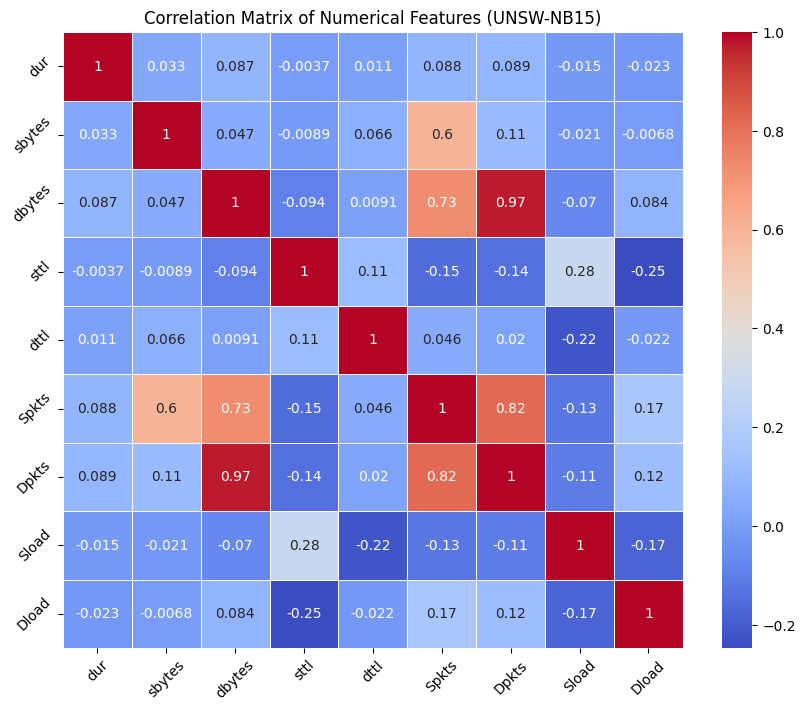

In [43]:
# Select relevant columns and convert to Pandas
df_pd = df.select(numerical_cols).toPandas()
corr_matrix = df_pd.corr()
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features (UNSW-NB15)")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [46]:
# encode categorical columns
categorical_cols = ["proto", "service", "state"]
indexers = [StringIndexer(inputCol=c, outputCol=c+"_index") for c in categorical_cols]

for indexer in indexers:
    df = indexer.fit(df).transform(df)

IllegalArgumentException: requirement failed: Output column proto_index already exists.

In [47]:
# assembling of features
feature_cols = ["proto_index", "service_index", "state_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

In [48]:
# Chi-square requires label column to be categorical (use attack_cat_index if already indexed)
from pyspark.ml.stat import ChiSquareTest
chi_df = df.select("features", "attack_cat_index")
ChiSquareTest.test(chi_df, "features", "attack_cat_index").show(truncate=False)

+-------------+----------------+---------------------------------------------------------+
|pValues      |degreesOfFreedom|statistics                                               |
+-------------+----------------+---------------------------------------------------------+
|[0.0,0.0,0.0]|[1330, 120, 150]|[1529096.4645816796,657897.4119156346,1063402.1173250854]|
+-------------+----------------+---------------------------------------------------------+



In [ ]:
#df = df.drop("id", "srcip", "sport", "dstip", "dsport", "is_sm_ips_ports")  # Keep only engineered and numeric fields

In [ ]:
df.select("dur", "sbytes", "dbytes", "sttl", "dttl", "Spkts", "Dpkts").describe().show()

+-------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+
|summary|               dur|           sbytes|            dbytes|             sttl|              dttl|            Spkts|             Dpkts|
+-------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+
|  count|           2539739|          2539739|           2539739|          2539739|           2539739|          2539739|           2539739|
|   mean|0.6588634003800393|4340.072263330996| 36432.01132478574|62.78149802007214|   30.770440978384| 33.2925678583508|42.731821655689814|
| stddev|13.925767633289283|56409.39812286232|161105.30400824756|74.62669956848524|42.851922189518724|76.28775585678378|121.50842004704197|
|    min|               0.0|                0|                 0|                0|                 0|                0|                 0|
|    max|         87

In [ ]:
df_sample = df.sample(withReplacement=False, fraction=0.05, seed=42).toPandas()

In [49]:
# cast numerical columns
numeric_cols = ["dur", "sbytes", "dbytes", "sttl", "dttl", "Spkts", "Dpkts", "Sload", "Dload", "ct_ftp_cmd", "ct_flw_http_mthd"]
for c in numeric_cols:
    df = df.withColumn(c, col(c).cast("double"))

In [50]:
# preparing labels for classification
# Binary classification
df_binary = df.withColumn("label", when(df["label"] == 1, 1).otherwise(0))

# Multi-class classification
# 'attack_cat_index' already created by StringIndexer

In [51]:
# Shuffle the DataFrame
df_shuffled = df_binary.orderBy(rand())

In [67]:
# train test splitting of the features
train_data, val_data, test_data = df_shuffled.randomSplit([0.6, 0.2, 0.2], seed=42)

In [ ]:
# training the binary classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, maxBins=150)
rf_model = rf.fit(train_data)

In [60]:
#make predictions
predictions = rf_model.transform(test_data)
predictions.select("label", "prediction", "probability").show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.91401340578661...|
|    0|       0.0|[0.99399333360352...|
+-----+----------+--------------------+
only showing top 20 rows



In [61]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC for Binary Classification: {auc}")

AUC for Binary Classification: 0.8972791288543884


In [ ]:
# train and test for the multi classifier
# Shuffle the DataFrame
df_shuffled_2 = df.orderBy(rand())

#run trining validation and testing
train_data_mc, val_data_mc, test_data_mc = df.randomSplit([0.6, 0.2, 0.2], seed=42)

In [ ]:
# train the model (multi) classifier
rf_mc = RandomForestClassifier(
    labelCol="attack_cat_index",
    featuresCol="features",
    numTrees=100,
    maxBins=150  # ensure this is >= highest cardinality of any categorical feature
)

rf_mc_model = rf_mc.fit(train_data_mc)

In [ ]:
# validate using validation set
val_predictions_mc = rf_mc_model.transform(val_data_mc)

evaluator = MulticlassClassificationEvaluator(
    labelCol="attack_cat_index",
    predictionCol="prediction",
    metricName="accuracy"  # or "f1", "weightedPrecision", "weightedRecall"
)
val_auc = evaluator.evaluate(val_predictions_mc)
print(f"Validation AUC: {val_auc}")

Validation AUC: 0.9715308944195113


In [ ]:
test_predictions_mc = rf_mc_model.transform(test_data_mc)

test_accuracy = evaluator.evaluate(test_predictions_mc)
print(f"Test Accuracy (Multi-class RF): {test_accuracy}")

Test Accuracy (Multi-class RF): 0.9722138558663903


In [ ]:
evaluator_mc = MulticlassClassificationEvaluator(
    labelCol="attack_cat_index",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator_mc.evaluate(test_predictions_mc)
print(f"Accuracy for Multi-Class Classification: {accuracy}")


Accuracy for Multi-Class Classification: 0.9722138558663903


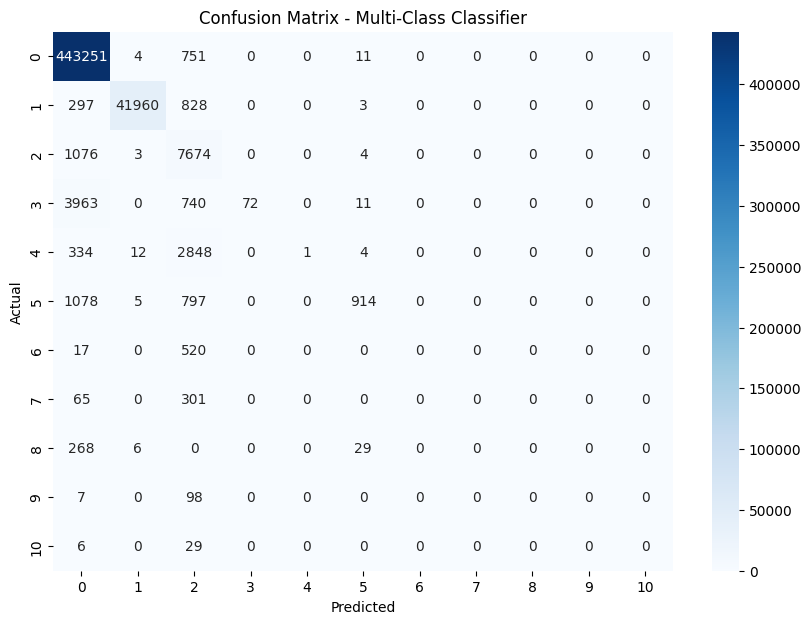

In [ ]:
preds_pd = test_predictions_mc.select("attack_cat_index", "prediction").toPandas()

# Compute confusion matrix
cm = confusion_matrix(preds_pd["attack_cat_index"], preds_pd["prediction"])

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Multi-Class Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
print(classification_report(preds_pd["attack_cat_index"], preds_pd["prediction"]))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    665646
         1.0       1.00      0.97      0.99     64500
         2.0       0.57      0.62      0.59     13205
         3.0       1.00      0.02      0.03      7244
         4.0       0.36      0.00      0.00      4862
         5.0       0.00      0.00      0.00      4180
         6.0       0.00      0.00      0.00       814
         7.0       0.00      0.00      0.00       539
         8.0       0.00      0.00      0.00       468
         9.0       0.00      0.00      0.00       163
        10.0       0.00      0.00      0.00        48

    accuracy                           0.97    761669
   macro avg       0.35      0.24      0.24    761669
weighted avg       0.96      0.97      0.96    761669



In [ ]:
print(classification_report(
    preds_pd["attack_cat_index"],
    preds_pd["prediction"],
    digits=3
))

              precision    recall  f1-score   support

         0.0      0.984     0.998     0.991    444017
         1.0      0.999     0.974     0.986     43088
         2.0      0.526     0.876     0.657      8757
         3.0      1.000     0.015     0.030      4786
         4.0      1.000     0.000     0.001      3199
         5.0      0.936     0.327     0.485      2794
         6.0      0.000     0.000     0.000       537
         7.0      0.000     0.000     0.000       366
         8.0      0.000     0.000     0.000       303
         9.0      0.000     0.000     0.000       105
        10.0      0.000     0.000     0.000        35

    accuracy                          0.972    507987
   macro avg      0.495     0.290     0.286    507987
weighted avg      0.975     0.972     0.964    507987



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
